In [93]:
import os
import sys

path = os.getcwd()
par_path = os.path.abspath(os.pardir)
sys.path.append(par_path)

from utils.data import ExtractROI, AtlasDataset

import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import torch

import csv
import math
import random as rand
from tqdm import tqdm

from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

from models.unet import UNet
from models.moment_unet import *

from monai.metrics import HausdorffDistanceMetric
from monai.metrics import DiceMetric, MeanIoU
from monai.transforms import AsDiscrete, EnsureType

## **PURPOSE**

This notebook is intended to extract ROIs from the ABC Atlas dataset.

## **Extract ROIs**

You will need to manually delete the save directories in order to regenerate to ROIs as a precaution against accidentally running and overwriting. The following are examples of the ExtractROI class being used. This extractor performs extractions in terms of patches in a grid in the original image. The **ROIExtractor2** performs extractions in terms of random coordinates, so there may be overlapping ROIs that are extracted. This other extractor takes *num_samples* instead of some sampling rate per image.

In [94]:
# Extract ROIs and ensure the ROIs' assigned label is the center of the ROI
ROI_size = (64, 64)
sampling_rate = 0.8
str_sampling_rate = str(sampling_rate).replace('.', '_')

extract_dir = '/nafs/dtward/allen/npz_files/'
save_dir = '/nafs/dtward/allen/rois/'
sub_save_dir = f"{ROI_size[0]}x{ROI_size[1]}_sample_rate_{str_sampling_rate}_center/"
abs_save_dir = os.path.join(save_dir, sub_save_dir)

if not os.path.exists(abs_save_dir):
    os.makedirs(abs_save_dir)
    extractor_center = ExtractROI(extract_dir=extract_dir, save_dir=abs_save_dir)
    extractor_center.extract_ROI(ROI_size=ROI_size, sampling_rate=sampling_rate, label_mode='center')
else:
    print(f"{abs_save_dir} already exists. If you intend to re-extract the ROIs, please delete the directory first.")

# Extract ROIs and ensure the ROIs' assigned labels are maintained as an n x n where each pixel is some label (segmentation)
ROI_size = (64, 64)
sampling_rate = 0.8
str_sampling_rate = str(sampling_rate).replace('.', '_')

extract_dir = '/nafs/dtward/allen/npz_files/'
save_dir = '/nafs/dtward/allen/rois/'
sub_save_dir = f"{ROI_size[0]}x{ROI_size[1]}_sample_rate_{str_sampling_rate}_all/"
abs_save_dir = os.path.join(save_dir, sub_save_dir)

if not os.path.exists(abs_save_dir):
    os.makedirs(abs_save_dir)
    extractor_all = ExtractROI(extract_dir=extract_dir, save_dir=abs_save_dir)
    extractor_all.extract_ROI(ROI_size=ROI_size, sampling_rate=sampling_rate, label_mode='all')
else:
    print(f"{abs_save_dir} already exists. If you intend to re-extract the ROIs, please delete the directory first.")

# Extract ROIs and ensure the ROIs' assigned label is the mode of all the labels in the ROI
ROI_size = (64, 64)
sampling_rate = 0.8
str_sampling_rate = str(sampling_rate).replace('.', '_')

extract_dir = '/nafs/dtward/allen/npz_files/'
save_dir = '/nafs/dtward/allen/rois/'
sub_save_dir = f"{ROI_size[0]}x{ROI_size[1]}_sample_rate_{str_sampling_rate}_mode/"
abs_save_dir = os.path.join(save_dir, sub_save_dir)

if not os.path.exists(abs_save_dir):
    os.makedirs(abs_save_dir)
    extractor_all = ExtractROI(extract_dir=extract_dir, save_dir=abs_save_dir)
    extractor_all.extract_ROI(ROI_size=ROI_size, sampling_rate=sampling_rate, label_mode='mode')
else:
    print(f"{abs_save_dir} already exists. If you intend to re-extract the ROIs, please delete the directory first.")

/nafs/dtward/allen/rois/64x64_sample_rate_0_5_center/ already exists. If you intend to re-extract the ROIs, please delete the directory first.
/nafs/dtward/allen/rois/64x64_sample_rate_0_5_all/ already exists. If you intend to re-extract the ROIs, please delete the directory first.
/nafs/dtward/allen/rois/64x64_sample_rate_0_5_mode/ already exists. If you intend to re-extract the ROIs, please delete the directory first.


## **Dataloader**

In [95]:
# To acutally load the ROIs, you will first need to run the above cell and paste in the corresponding outputted directory for train and test
train_dir = '/nafs/dtward/allen/rois/64x64_sample_rate_0_8_all/train/'
test_dir = '/nafs/dtward/allen/rois/64x64_sample_rate_0_8_all/test/'

# label_map_file specifies how to translate the parcellation index to a label. Can use different levels of granularity: divisions.csv, organs.csv, structures.csv, substructures.csv, categories.csv
label_map_file = '/nafs/dtward/allen/rois/categories.csv'

train_dataset = AtlasDataset(data_dir=train_dir, label_map_file=label_map_file)
test_dataset = AtlasDataset(data_dir=test_dir, label_map_file=label_map_file)

bs = 16
train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=bs, shuffle=True)

print(train_dataset.num_classes)
label_sample = next(iter(train_loader))[1]
print(label_sample.shape)

5
torch.Size([16, 1, 64, 64])


## **Testing**

In [96]:
sample_imgs, sample_labels = next(iter(train_loader))

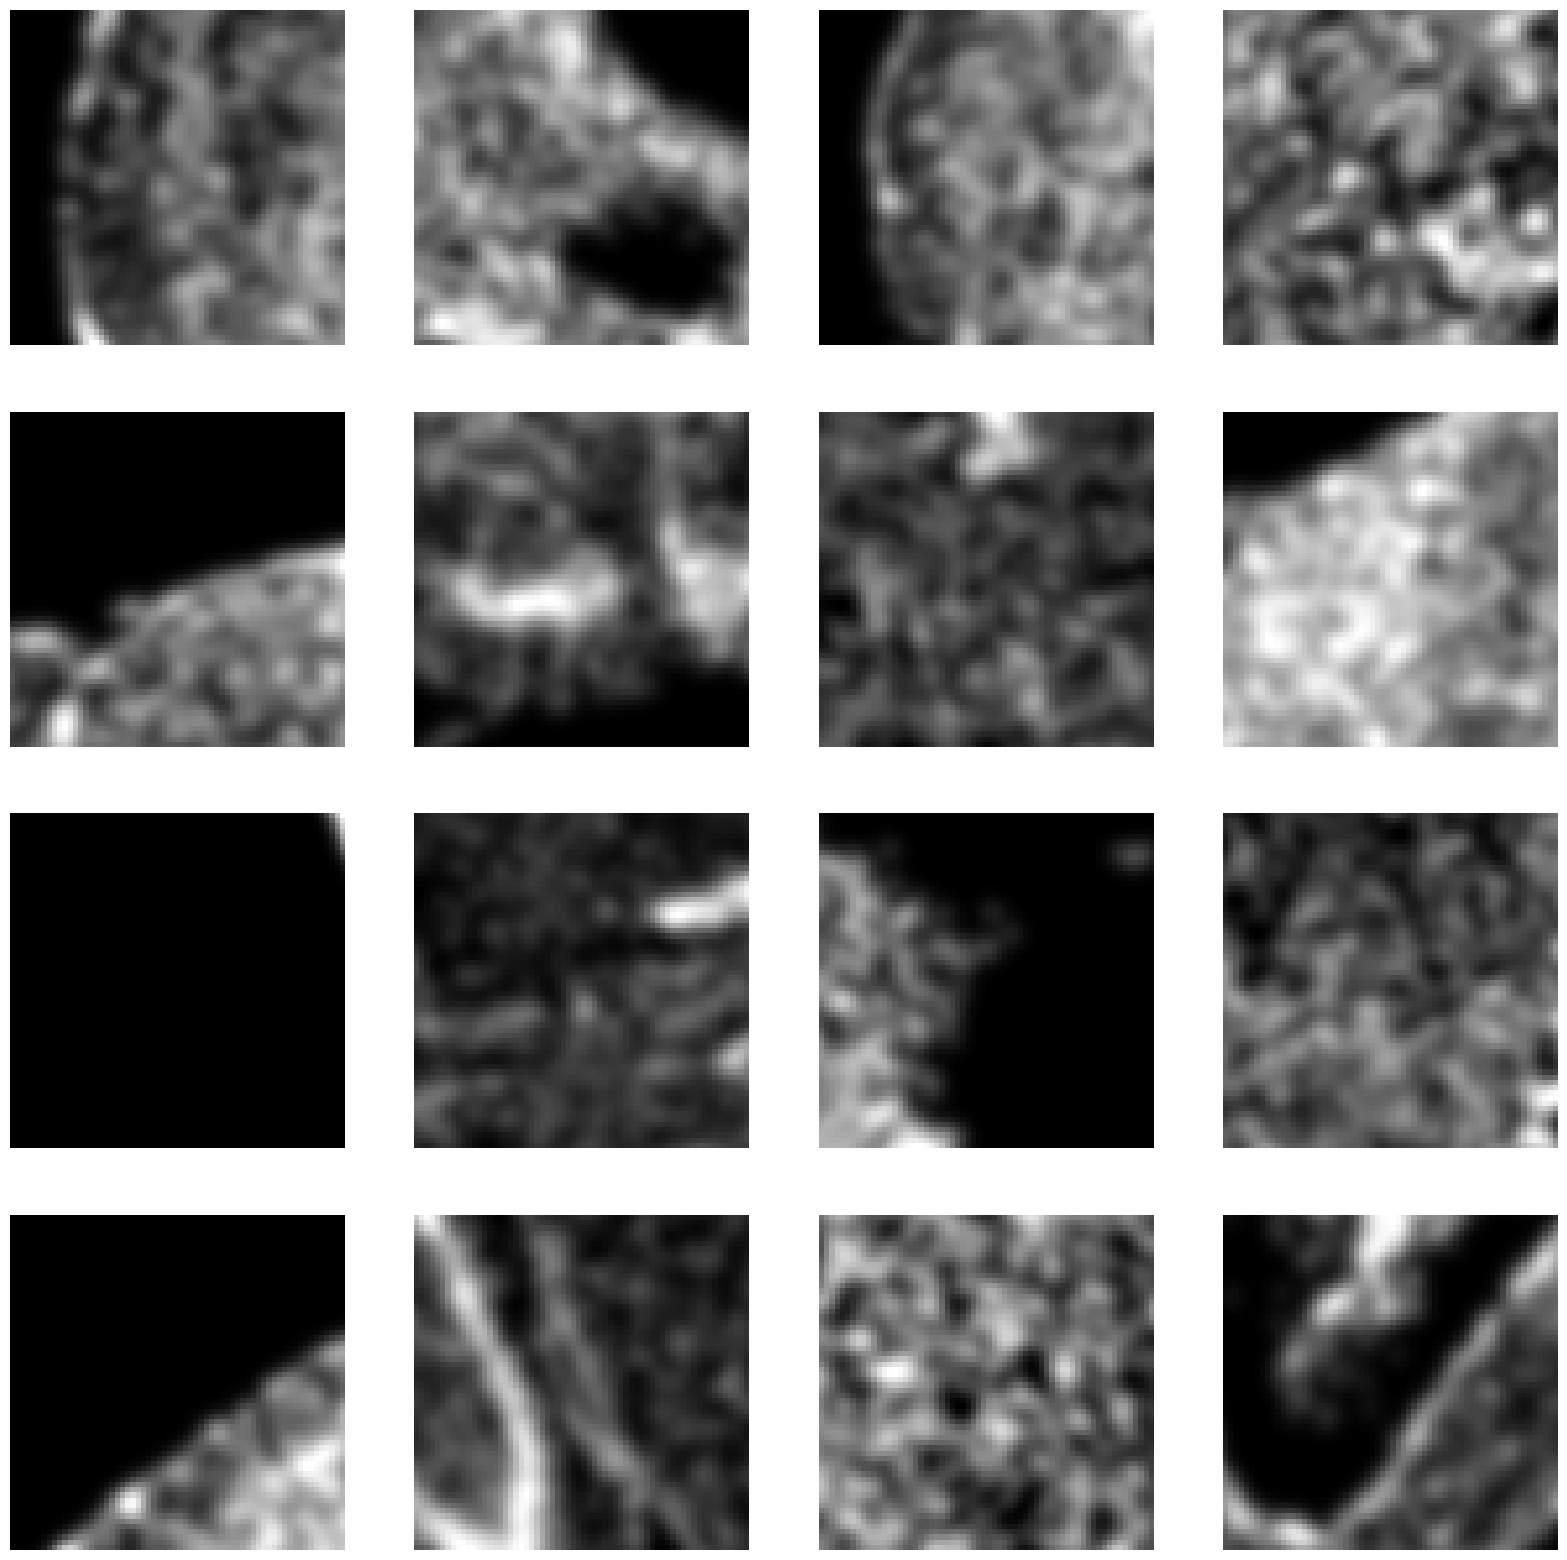

In [97]:
# Display the first 16 images and their labels
plt.figure(figsize=(20, 20))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(sample_imgs[i, 0, :, :], cmap='gray')
    plt.axis('off')

{'grey', 'unassigned'}
{'grey', 'unassigned', 'fiber tracts'}
{'grey', 'unassigned'}
{'grey', 'fiber tracts'}
{'grey', 'unassigned'}
{'grey', 'unassigned', 'fiber tracts'}
{'brain-unassigned', 'grey', 'VS', 'fiber tracts'}
{'grey', 'unassigned'}
{'grey', 'unassigned'}
{'brain-unassigned', 'grey', 'fiber tracts'}
{'grey', 'unassigned', 'fiber tracts'}
{'grey', 'fiber tracts'}
{'grey', 'unassigned'}
{'brain-unassigned', 'grey', 'unassigned', 'fiber tracts'}
{'grey'}
{'grey', 'fiber tracts'}


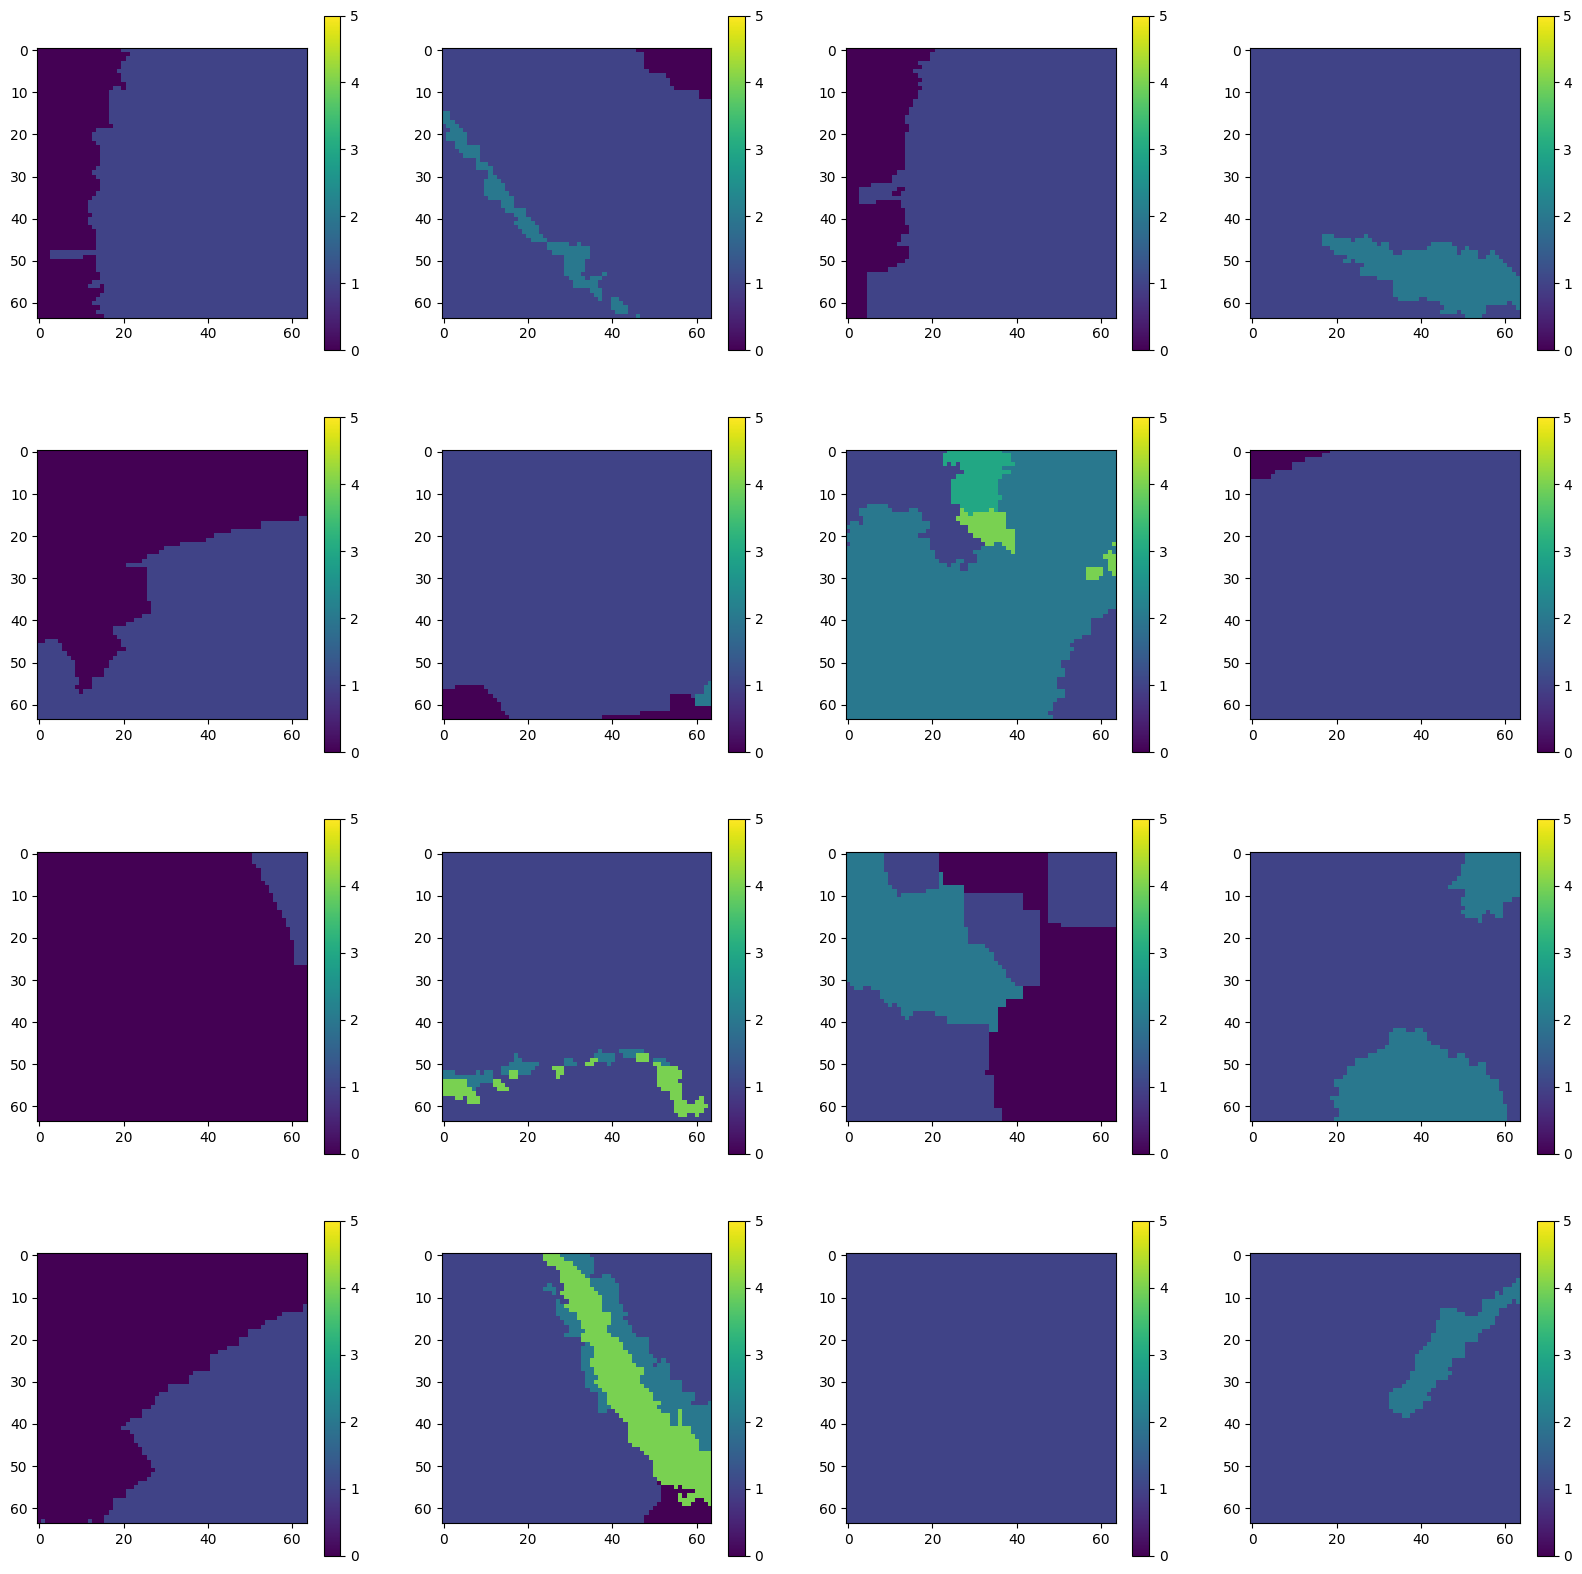

In [98]:
# Display the first 16 labels and unique labels
cmap = plt.get_cmap('viridis')
norm = plt.Normalize(vmin=0, vmax=train_dataset.num_classes)
colors = cmap(norm(sample_labels[0, 0, :, :]))

# labels
plt.figure(figsize=(20, 20))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(sample_labels[i, 0, :, :], cmap=cmap, norm=norm)
    labels = np.unique(sample_labels[i, 0, :, :])
    plt.colorbar(plt.imshow(sample_labels[i, 0, :, :], cmap=cmap, norm=norm))

    #convert from list of integer labels to string name in {p_index : {name: name1, index: idx1}}
    string_labels = set()
    for label in labels:
        for key, value in train_dataset.label_map.items():
            if value['index'] == label:
                string_labels.add(value['name'])
    print(string_labels)
